# Many to One - Multi Layer - MNIST LSTM Model

In [266]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
import time

In [267]:
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [268]:
# Create Parameter class to store weights, biases and their gradients (Similar to Tensor)
class Parameter:
  def __init__(self, name, value):
    self.name = name
    self.value = value #parameter value
    self.grad = np.zeros_like(value) #derivative
    self.m_grad = np.zeros_like(value) #momentum for AdaGrad (memory variables for Adagrad)

  def __repr__(self):
    return "Parameter [name = " + self.name + ", value.shape = "+ str(self.value.shape) +"]"

  def zero_grad(self):
    self.grad = np.zeros_like(self.value)

In [269]:
class LSTM_Parameters:
  def __init__ (self, hidden_size, input_size, output_size):
    self.W_f = Parameter('W_f', np.random.randn(hidden_size, input_size+hidden_size)*0.01)#INPUT to hidden layer of forgot gate [input_size+hidden_size, hidden_size]
    self.W_i = Parameter('W_i', np.random.randn(hidden_size, input_size+hidden_size)*0.01) #INPUT to hidden layer of input gate [input_size+hidden_size, hidden_size]
    self.W_g = Parameter('W_g', np.random.randn(hidden_size, input_size+hidden_size)*0.01) #INPUT to hidden layer of  gate [input_size+hidden_size, hidden_size]
    self.W_o = Parameter('W_o', np.random.randn(hidden_size, input_size+hidden_size)*0.01) #INPUT to hidden layer of output gate [input_size+hidden_size, hidden_size]
    self.W_hy = Parameter('W_hy', np.random.randn(output_size, hidden_size)*0.01) #hidden to output [hidden_size, input_size]

    self.b_f = Parameter('b_f',np.zeros((hidden_size, 1)))  #(hidden_size X 1)
    self.b_i = Parameter('b_i',np.zeros((hidden_size, 1)))  #(hidden_size X 1)
    self.b_g = Parameter('b_g',np.zeros((hidden_size, 1)))  #(hidden_size X 1)
    self.b_o = Parameter('b_o',np.zeros((hidden_size, 1)))  #(hidden_size X 1)
    self.b_hy = Parameter('b_hy',np.zeros((output_size,1))) #output layer bias [hidden_size,1]
  
  def zero_grad(self):
    for p in [self.W_f, self.W_i, self.W_g, self.W_o, self.W_hy,self.b_f, self.b_i, self.b_g, self.b_o, self.b_hy]:
      p.zero_grad()
  
  def clip_grad(self):
    for g in [self.W_f, self.W_i, self.W_g, self.W_o, self.W_hy,self.b_f, self.b_i, self.b_g, self.b_o, self.b_hy]:
      np.clip(g.grad, -1, 1, out=g.grad) # clip to mitigate exploding gradients
  
  def adagrad_optimizer(self, learning_rate = 1e-1):
    for p in [self.W_f, self.W_i, self.W_g, self.W_o, self.W_hy,self.b_f, self.b_i, self.b_g, self.b_o, self.b_hy]:
      p.m_grad += p.grad * p.grad
      p.value += -learning_rate * p.grad / np.sqrt(p.m_grad + 1e-8) # adagrad update
      

In [270]:
# LSTM Class to store all the weights and biases
class LSTM:
  def __init__(self, hidden_size, input_size, output_size, sequence_length, learning_rate = 1e-1, weight_sd = 0.1, lstm_layers = 1):
    self.hidden_size = hidden_size
    self.input_size = input_size
    self.output_size = output_size
    self.sequence_length = sequence_length;
    self.learning_rate = learning_rate;
    self.weight_sd = weight_sd;
    self.lstm_layers = lstm_layers;
    self.lstm_parameters = []
    self.lstm_parameters.append(LSTM_Parameters(hidden_size, input_size, output_size))

    for i in range(1,lstm_layers):
      self.lstm_parameters.append(LSTM_Parameters(hidden_size, hidden_size, output_size))
    
    self.plot_iter = np.zeros((0))
    self.plot_loss = np.zeros((0))
    self.smt_loss = np.zeros((0))

    self.train_accuracy = np.zeros((0))
    self.test_accuracy = np.zeros((0))


  def __repr__(self):
    return "LSTM: [input_size = "+str(self.input_size) +", hidden_size = "+ str(self.hidden_size)+", sequence_length = "+str(self.sequence_length)+", lstm_layers = "+str(self.lstm_layers)+", learning_rate = "+str(self.learning_rate)+"]"
  
  def zero_grads(self):
    for i in range(self.lstm_layers):
      self.lstm_parameters[i].zero_grad()
  
  def clip_grads(self):
    for i in range(self.lstm_layers):
      self.lstm_parameters[i].clip_grad()

  def adagrad_optimizer(self):
    for i in range(self.lstm_layers):
      self.lstm_parameters[i].adagrad_optimizer()

  # Sigmoid Function:
  def sigmoid(self,x):
    return 1 / (1 + np.exp(-x))
  
  def LSTM_cell_forward(self, input, h_prev, c_prev, layer):
    # Stack h and x together
    input = input.reshape((input.shape[0], 1))

    inp = np.vstack((h_prev, input)) # h before x


    # Forward Pass through four gates of LSTM
    f = self.sigmoid(np.dot(self.lstm_parameters[layer].W_f.value, inp) + self.lstm_parameters[layer].b_f.value)
    i = self.sigmoid(np.dot(self.lstm_parameters[layer].W_i.value, inp) + self.lstm_parameters[layer].b_i.value)
    g = np.tanh(np.dot(self.lstm_parameters[layer].W_g.value, inp) + self.lstm_parameters[layer].b_g.value)
    o = self.sigmoid(np.dot(self.lstm_parameters[layer].W_o.value, inp)+self.lstm_parameters[layer].b_o.value)

    # Calulate cell state: (Element Wise multiplication and addition)
    c_t = np.multiply(c_prev, f) + np.multiply(i, g)
    c_tanh = np.tanh(c_t)
    h_t = np.multiply(c_tanh,o)   #ht generated for current timestemp (hidden_size X 1)

    return h_t, c_t, f, i, g, o

  def LSTM_cell_calculate_y(self, h_t, layer):
    # Calculate y 
    y = np.dot(self.lstm_parameters[layer].W_hy.value, h_t) + self.lstm_parameters[layer].b_hy.value #y before passing through softmax function (input_size X 1)
    
    # softmax function:
    p = np.exp(y) / np.sum(np.exp(y)) # (input_size X 1)
    return y, p

  def modified_forward(self, input, h_prev, c_prev):
    h_t, c_t, f_t, i_t, g_t, o_t = np.empty(self.lstm_layers, dtype=object), np.empty(self.lstm_layers, dtype=object), np.empty(self.lstm_layers, dtype=object), np.empty(self.lstm_layers, dtype=object), np.empty(self.lstm_layers, dtype=object),np.empty(self.lstm_layers, dtype=object)
    y = None
    p = None

    for i in range(self.lstm_layers):
      h_t[i], c_t[i], f_t[i], i_t[i], g_t[i], o_t[i] = self.LSTM_cell_forward(input, h_prev[i], c_prev[i], i)
      input = h_t[i]
    
    y, p = self.LSTM_cell_calculate_y(h_t[self.lstm_layers-1], self.lstm_layers-1)

    return h_t, c_t, f_t, i_t, g_t, o_t, y, p


  def modified_forward_MNIST(self, input, h_prev, c_prev, is_out):
    h_t, c_t, f_t, i_t, g_t, o_t = np.empty(self.lstm_layers, dtype=object), np.empty(self.lstm_layers, dtype=object), np.empty(self.lstm_layers, dtype=object), np.empty(self.lstm_layers, dtype=object), np.empty(self.lstm_layers, dtype=object),np.empty(self.lstm_layers, dtype=object)
    y = None
    p = None

    for i in range(self.lstm_layers):
      h_t[i], c_t[i], f_t[i], i_t[i], g_t[i], o_t[i] = self.LSTM_cell_forward(input, h_prev[i], c_prev[i], i)
      input = h_t[i]

    if(is_out):
      y, p = self.LSTM_cell_calculate_y(h_t[self.lstm_layers-1], self.lstm_layers-1)
    
    return h_t, c_t, f_t, i_t, g_t, o_t, y, p


  def samle_LSTM_MNIST(self, input):
    h_t = np.empty(self.lstm_layers, dtype=object)
    c_t = np.empty(self.lstm_layers, dtype=object)
    for i in range(self.lstm_layers):
      h_t[i] = np.zeros((self.hidden_size,1))
      c_t[i] = np.zeros((self.hidden_size,1))

    for t in range(len(input)):
      h_t, c_t, _, _, _, _, _, p = self.modified_forward_MNIST(input[t], h_t, c_t, (t == (len(input)-1)))

    return np.random.choice(range(self.output_size), p=p.ravel())


  def LSTM_cell_backpropogation(self,cs_prev, hs_prev, xs, o_s, f_s, g_s, i_s, cs, dh_next, dc_next, layer):
    dc_tanh = dh_next * o_s # dL/dc_tanh
    dct = dc_tanh*(1-(np.tanh(cs)**2)) + dc_next # dL/dct -->dct

    dcnext = dct*f_s #dL/dc_(t-1)
    xs = xs.reshape((xs.shape[0], 1))

    inp = np.vstack((hs_prev, xs)) # h before x

    #Output Gate
    d_ot = dh_next*np.tanh(cs)
    dW_o_row = d_ot * (o_s*(1-o_s))
    self.lstm_parameters[layer].W_o.grad += np.dot(dW_o_row, inp.T)
    self.lstm_parameters[layer].b_o.grad += dW_o_row

    #Forget Gate
    d_ft = dct*cs_prev
    dW_f_row = d_ft * (f_s*(1-f_s))
    self.lstm_parameters[layer].W_f.grad += np.dot(dW_f_row,inp.T)
    self.lstm_parameters[layer].b_f.grad += dW_f_row

    #Input Gate
    d_it = dct*g_s
    dW_i_row = d_it * (i_s*(1-i_s))
    self.lstm_parameters[layer].W_i.grad += np.dot(dW_i_row,inp.T)
    self.lstm_parameters[layer].b_i.grad += dW_i_row

    #Activation Gate
    d_gt = dct*i_s
    dW_g_row = d_gt * (1-(g_s**2))
    self.lstm_parameters[layer].W_g.grad += np.dot(dW_g_row,inp.T)
    self.lstm_parameters[layer].b_g.grad += dW_g_row
    
    dhnext = np.dot(self.lstm_parameters[layer].W_o.value[:, 0:self.hidden_size].T, dW_o_row) + np.dot(self.lstm_parameters[layer].W_f.value[:, 0:self.hidden_size].T, dW_f_row) + np.dot(self.lstm_parameters[layer].W_i.value[:, 0:self.hidden_size].T, dW_i_row) + np.dot(self.lstm_parameters[layer].W_g.value[:, 0:self.hidden_size].T, dW_g_row)

    dxnext = np.dot(self.lstm_parameters[layer].W_o.value[:, self.hidden_size:].T, dW_o_row) + np.dot(self.lstm_parameters[layer].W_f.value[:, self.hidden_size:].T, dW_f_row) + np.dot(self.lstm_parameters[layer].W_i.value[:, self.hidden_size:].T, dW_i_row) + np.dot(self.lstm_parameters[layer].W_g.value[:, self.hidden_size:].T, dW_g_row)

    return dhnext, dcnext, dxnext


  def modified_lossFun_LSTM_MNIST(self, input, target, hprev, cprev):
    # Dictonary to store inputs, outputs, and probabilities on each state
    xs, ys, ps = {}, {}, {}

    #Dictonary of Array of Arrays to store hidden states, cell states, f, i,g,and o for each layer and state
    hs, cs, f_s, i_s, g_s, o_s = {}, {}, {}, {}, {}, {}

    #store the hidden state and cell state at time stemp t-1
    hs[-1] = np.copy(hprev)
    cs[-1] = np.copy(cprev)

    # Initialize loss
    loss = 0

    # forward pass
    for t in range(len(input)):
      xs[t] = input[t]
      # Forward pass:
      hs[t], cs[t], f_s[t], i_s[t], g_s[t], o_s[t], ys[t], ps[t] = self.modified_forward_MNIST(xs[t], hs[t-1], cs[t-1], (t == (len(input)-1)))

    #Cross Entropy Loss
    loss += -np.log(ps[t][target,0]) # softmax (cross-entropy loss)

    self.zero_grads()

    dhnext = np.empty(self.lstm_layers, dtype=object)
    dcnext = np.empty(self.lstm_layers, dtype=object)
    for i in range(self.lstm_layers):
      dhnext[i] = np.zeros((self.hidden_size,1)) # reset LSTM memory
      dcnext[i] = np.zeros((self.hidden_size,1)) # reset LSTM cell memory

    #Calculate Loss between actual and predicted
    dy = np.copy(ps[t])
    dy[target] -= 1
    
    # ht to y
    self.lstm_parameters[self.lstm_layers-1].W_hy.grad += np.dot(dy, hs[t][self.lstm_layers-1].T) #dWhy += np.dot(Output_Delta, Hidden_Layer.T)
    self.lstm_parameters[self.lstm_layers-1].b_hy.grad += dy # bias += sum(Output_Delta)

    dhnext[self.lstm_layers-1] += np.dot(self.lstm_parameters[self.lstm_layers-1].W_hy.value.T, dy) # backprop into h ===> dL/dht --> dht


    for t in reversed(range(len(input[0]))):      
      for layer in reversed(range(1, self.lstm_layers)):
        dhnext[layer], dcnext[layer], dxnext = self.LSTM_cell_backpropogation(cs[t-1][layer], 
                                                                      hs[t-1][layer],
                                                                      hs[t][layer-1], 
                                                                      o_s[t][layer],
                                                                      f_s[t][layer], 
                                                                      g_s[t][layer], 
                                                                      i_s[t][layer],
                                                                      cs[t][layer], 
                                                                      dhnext[layer], 
                                                                      dcnext[layer], 
                                                                      layer)
        dhnext[layer-1] += dxnext
      
      dhnext[0], dcnext[0],_ = self.LSTM_cell_backpropogation(cs[t-1][0], 
                                                                      hs[t-1][0],
                                                                      xs[t], 
                                                                      o_s[t][0],
                                                                      f_s[t][0], 
                                                                      g_s[t][0], 
                                                                      i_s[t][0],
                                                                      cs[t][0], 
                                                                      dhnext[0], 
                                                                      dcnext[0], 
                                                                      0)
    self.clip_grads()

    return loss, hs[len(input[0])-1], cs[len(input[0])-1]



  # Function to display updated output to console
  def update_status(self, epoch, batch, len_x, smooth_loss):
    # Clear and plot
    fig, axs = plt.subplots(2, 2, figsize= (10,10))
    axs[0, 0].plot(self.plot_iter, self.plot_loss)
    axs[0, 0].set_title('Cross Entropy Loss')
    axs[0, 0].set_xlabel("Steps")
    axs[0, 0].set_ylabel("Loss")

    axs[0, 1].plot(self.plot_iter, self.smt_loss, color = 'orange')
    axs[0, 1].set_title('Smooth Loss')
    axs[0, 1].set_xlabel("Steps")
    axs[0, 1].set_ylabel("Loss")

    axs[1, 0].plot(self.train_accuracy, marker='o', color = 'green')
    axs[1, 0].set_title('Train Data Accuracy')
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Accuracy [%]")

    axs[1, 1].plot(self.test_accuracy, marker='o', color = 'red')
    axs[1, 1].set_title('Test Data Accuracy')
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Accuracy [%]")

    display.clear_output(wait=True)
    plt.show()

    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch, len_x, 100. * batch / len_x, smooth_loss))
    

  def train(self, X_dataset, Y_dataset, smooth_loss, epoch):
    # For each dataset 
    for batch in range(len(X_dataset)):
      with DelayedKeyboardInterrupt():
        hprev = np.empty(self.lstm_layers, dtype=object)
        cprev = np.empty(self.lstm_layers, dtype=object)
        for i in range(self.lstm_layers):
          hprev[i] = np.zeros((self.hidden_size,1))
          cprev[i] = np.zeros((self.hidden_size,1))

        loss, hprev, cprev = self.modified_lossFun_LSTM_MNIST(X_dataset[batch], Y_dataset[batch], hprev, cprev)
        # Update overall loss function
        smooth_loss = smooth_loss * 0.999 + loss * 0.001
        
        # perform parameter update with Adagrad
        self.adagrad_optimizer()


        if batch % 200 == 0:
          self.plot_iter = np.append(self.plot_iter, [batch+epoch*len(Y_dataset)])
          self.plot_loss = np.append(self.plot_loss, [loss])
          self.smt_loss = np.append(self.smt_loss, [smooth_loss])

          self.update_status(epoch, batch, len(X_dataset), smooth_loss)

    return smooth_loss
  

  def test(self, X_dataset, Y_dataset):
    test_loss = 0
    correct = 0
    
    for i in range(len(X_dataset)):
      predicted = self.samle_LSTM_MNIST(X_dataset[i])
      if(predicted == Y_dataset[i]):
        correct = correct + 1
      
    print('Total Correct: {}/{} ({:.3f}%)'.format(correct, len(Y_dataset), correct/len(Y_dataset) *100.0))

    return correct/len(Y_dataset)



In [271]:
import numpy as np
from urllib import request
import gzip
import pickle

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28,28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()
    
def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

# https://www.kaggle.com/berrywell/calculating-mnist-inverted-mnist-mean-std
def load_normalized():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    mnist_train_mean, mnist_train_std = mnist["training_images"].mean(), mnist["training_images"].flatten().std()
    mnist_test_mean, mnist_test_std = mnist["test_images"].flatten().mean(), mnist["test_images"].flatten().std()
    
    all_data = np.concatenate((mnist["training_images"], mnist["test_images"]), axis = 0)
    mnist_all_mean, mnist_all_std = all_data.flatten().mean(), all_data.flatten().std()

    print('MNIST train mean: {}, std: {}'.format(mnist_train_mean, mnist_train_std))
    print('MNIST test mean: {}, std: {}'.format(mnist_test_mean, mnist_test_std))
    print('MNIST all mean: {}, std: {}'.format(mnist_all_mean, mnist_all_std))
    return np.round_((mnist["training_images"]-mnist_all_mean)/(mnist_all_std), decimals=4), mnist["training_labels"], np.round_((mnist["test_images"]-mnist_all_mean)/(mnist_all_std), decimals=4), mnist["test_labels"]

if __name__ == '__main__':
    init()

Download complete.
Save complete.


In [272]:
print("Load MNIST Dataset: ")
x_train, y_train, x_test, y_test = load_normalized()

Load MNIST Dataset: 
MNIST train mean: 33.318421449829934, std: 78.56748998339798
MNIST test mean: 33.791224489795916, std: 79.17246322228644
MNIST all mean: 33.385964741253645, std: 78.6543736268941


In [273]:
print("Tranning Dataset Shape: ", x_train.shape)
print("Testing Dataset Shape: ",x_test.shape)

Tranning Dataset Shape:  (60000, 28, 28)
Testing Dataset Shape:  (10000, 28, 28)


Sample Input and Output Data: 


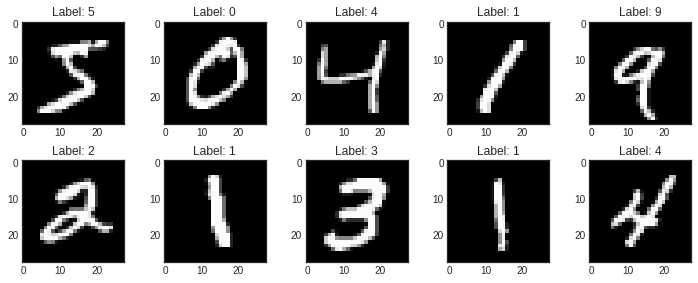

In [274]:
#Plots of Sample Input and Output Data
print("Sample Input and Output Data: ")
print("==============================")

num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(x_train[i].reshape(28,28), cmap='gray')
    ax.set_title('Label: {}'.format(y_train[i]))
      
plt.tight_layout()
plt.show()

In [275]:
print("Initialize LSTM Model for MNIST Digit Classification")
lstm = LSTM(100, 28, 10, 28, 1e-1, 0.1, 2)
smooth_loss = -np.log(1.0/len(x_train))*len(x_train[0]) # loss at iteration 0

Initialize LSTM Model for MNIST Digit Classification


In [276]:
print("Smooth loss at iteration 0: ", smooth_loss)

Smooth loss at iteration 0:  308.05879555371865


In [277]:
# Test and Train Accuracies before Trainning LSTM Model:
print("Train Data Test Result: ")
train_test = lstm.test(x_train, y_train)
lstm.train_accuracy = np.append(lstm.train_accuracy, train_test*100.0)

print("Test Data Test Result: ")
test_test = lstm.test(x_test, y_test)
lstm.test_accuracy = np.append(lstm.test_accuracy, test_test*100.0)


Train Data Test Result: 
Total Correct: 5944/60000 (9.907%)
Test Data Test Result: 
Total Correct: 993/10000 (9.930%)


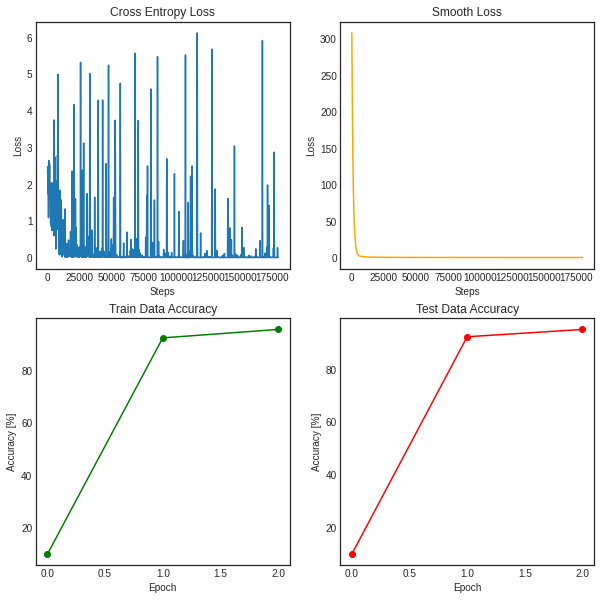

Train Epoch: 2 [59800/60000 (100%)]	Loss: 0.064903
Total Correct: 58137/60000 (96.895%)
Epoch:  2  TRAIN DATA TESTING ACCURACY: 0.96895
Total Correct: 9648/10000 (96.480%)
Epoch:  2  TEST DATA TESTING ACCURACY:  0.9648
Epoch:  2  Training Time:  6546.390764951706  secs
Epoch:  2  Execution Time:  8117.671349287033  secs


In [278]:
epochs = 3
#Start Training:
time0 = time.time()
start_time = time.time()
Total_Training_Time = 0

for epoch in range(epochs):
    smooth_loss = lstm.train(x_train, y_train, smooth_loss, epoch)
    Total_Training_Time += (time.time() - start_time)
    
    train_test = lstm.test(x_train, y_train)
    lstm.train_accuracy = np.append(lstm.train_accuracy, train_test*100.0)
    
    print("Epoch: ", epoch," TRAIN DATA TESTING ACCURACY:", train_test)

    test_test = lstm.test(x_test, y_test)
    lstm.test_accuracy = np.append(lstm.test_accuracy, test_test*100.0)

    print("Epoch: ", epoch, " TEST DATA TESTING ACCURACY: ", test_test)

    print("Epoch: ",epoch," Training Time: ", Total_Training_Time, " secs")
    print("Epoch: ",epoch," Execution Time: ", time.time()-time0, " secs")
    start_time = time.time()

In [279]:
for i in range(3):
  print('Epoch: {}, Train Data Accuracy: {}, Test Data Accuracy: {}'.format(i, lstm.test_accuracy[i], lstm.train_accuracy[i]))


Epoch: 0, Train Data Accuracy: 9.93, Test Data Accuracy: 9.906666666666666
Epoch: 1, Train Data Accuracy: 92.31, Test Data Accuracy: 92.25
Epoch: 2, Train Data Accuracy: 95.09, Test Data Accuracy: 95.45833333333333


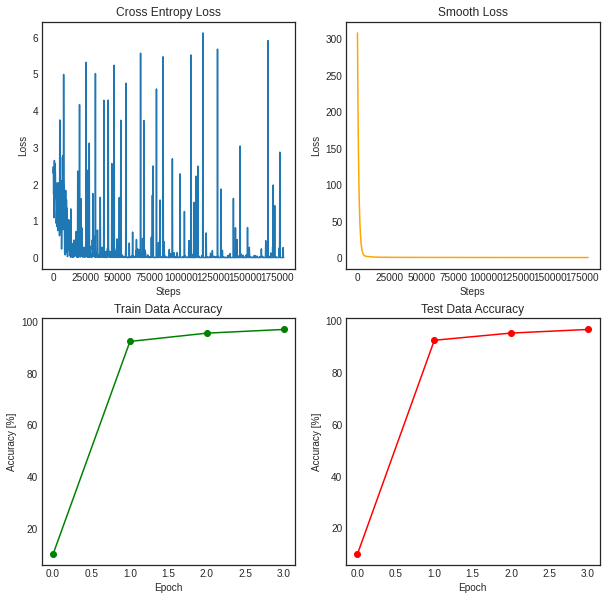

In [280]:
fig, axs = plt.subplots(2, 2, figsize= (10,10))
axs[0, 0].plot(lstm.plot_iter, lstm.plot_loss)
axs[0, 0].set_title('Cross Entropy Loss')
axs[0, 0].set_xlabel("Steps")
axs[0, 0].set_ylabel("Loss")

axs[0, 1].plot(lstm.plot_iter, lstm.smt_loss, color = 'orange')
axs[0, 1].set_title('Smooth Loss')
axs[0, 1].set_xlabel("Steps")
axs[0, 1].set_ylabel("Loss")

axs[1, 0].plot(lstm.train_accuracy, marker='o', color = 'green')
axs[1, 0].set_title('Train Data Accuracy')
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy [%]")

axs[1, 1].plot(lstm.test_accuracy, marker='o', color = 'red')
axs[1, 1].set_title('Test Data Accuracy')
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy [%]")

plt.show()

In [282]:
print("Train Data Accuracy after Epoch 2: ",lstm.train_accuracy[-1])
print("Test Data Accuracy after Epoch 2: ",lstm.test_accuracy[-1])

Train Data Accuracy after Epoch 2:  96.895
Test Data Accuracy after Epoch 2:  96.48
